In [3]:
import nibabel as nib
import mne

In [4]:
SUBJECT_DIR = "/home/carlos/Datasets/subjects/MNIAverage"
CEREBRA_DIR = "/home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62"

In [5]:
!mri_info --vox2ras $CEREBRA_DIR/CerebrA.nii

   1.00000    0.00000    0.00000  -96.00000 
   0.00000    1.00000    0.00000 -132.00000 
   0.00000    0.00000    1.00000  -78.00000 
   0.00000    0.00000    0.00000    1.00000 


In [6]:
!mri_info --vox2ras $CEREBRA_DIR/CerebrA.mgz

   1.00000    0.00000    0.00000  -96.00000 
   0.00000    1.00000    0.00000 -132.00000 
   0.00000    0.00000    1.00000  -78.00000 
   0.00000    0.00000    0.00000    1.00000 


In [40]:
cerebra_img = nib.load(f"{CEREBRA_DIR}/CerebrA.nii")
cerebra_img_data = cerebra_img.get_fdata()
cerebra_img.orthoview()
cerebra_img_data.shape

(193, 229, 193)

In [23]:
cerebra_img_data

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [22]:
cerebra_img

In [15]:
cerebra_img_data.shape

(193, 229, 193)

In [19]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
%matplotlib qt

In [33]:
import matplotlib.pyplot as plt
import random
import matplotlib.colors
ax = plt.figure().add_subplot(projection='3d')

xs = []
ys = []
zs = []
cs = []

norm=plt.Normalize(0,102)
cmap = get_cmap(102)

for x in range(0,cerebra_img_data.shape[0],1):
    for y in range(0,cerebra_img_data.shape[1],1):
        for z in range(0,cerebra_img_data.shape[2],1):
            if cerebra_img_data[x,y,z] == 11:
                xs.append(x)
                ys.append(y)
                zs.append(z)
                cs.append(cerebra_img_data[x,y,z])

ax.scatter(xs,ys,zs,c=cs,cmap=cmap)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([0,256])
ax.set_ylim([0,256])
ax.set_zlim([0,256])

(0.0, 256.0)

(256, 256, 256)

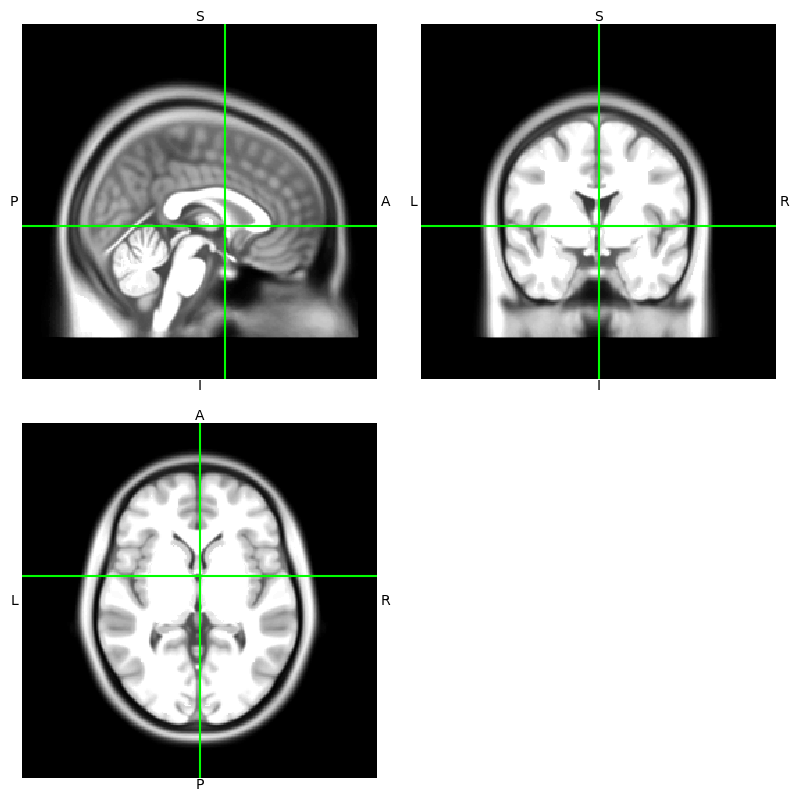

In [11]:
t1_img = nib.load(f"{SUBJECT_DIR}/mri/T1.mgz")
t1_data = t1_img.get_fdata()
t1_img.orthoview()
t1_img.shape

### Transform .nii to .mgz

In [49]:
!mri_convert $CEREBRA_DIR"/CerebrA.nii" $CEREBRA_DIR"/CerebrA.mgz"

mri_convert /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.nii /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz 
reading from /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.nii...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz...


### Switch to head coordinate frame and store in CerebrA_in_head.mgz

In [50]:
!mri_vol2vol --mov $CEREBRA_DIR"/CerebrA.mgz" --o $CEREBRA_DIR"/CerebrA_in_head.mgz" --regheader --targ $SUBJECT_DIR/mri/T1.mgz --interp nearest

movvol /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz
targvol /home/carlos/Datasets/subjects/MNIAverage/mri/T1.mgz
outvol /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA_in_head.mgz
invert 0
tal    0
talres 2
regheader 1
noresample 0
interp  nearest (0)
precision  float (3)
Gdiag_no  -1
Synth      0
SynthSeed  1694514331

Computing registration based on scanner-to-scanner

Final tkRAS-to-tkRAS Matrix is:
-1.00000   0.00000   0.00000   0.00000;
 0.00000   0.00000   1.00000   0.00000;
 0.00000  -1.00000   0.00000   0.00000;
 0.00000   0.00000   0.00000   1.00000;


Vox2Vox Matrix is:
-1.00000   0.00000   0.00000   224.50000;
 0.00000   0.00000   1.00000  -13.50000;
 0.00000  -1.00000   0.00000   224.50000;
 0.00000   0.00000   0.00000   1.00000;

Resampling
Output registration matrix is identity

mri_vol2vol done


In [51]:
cerebra_img = nib.load(f"{CEREBRA_DIR}/CerebrA.mgz")
cerebra_img_data = cerebra_img.get_fdata()
cerebra_img.orthoview()

ax = plt.figure().add_subplot(projection='3d')

xs = []
ys = []
zs = []
cs = []

norm=plt.Normalize(0,102)
cmap = get_cmap(102)

for x in range(0,cerebra_img_data.shape[0],1):
    for y in range(0,cerebra_img_data.shape[1],1):
        for z in range(0,cerebra_img_data.shape[2],1):
            if cerebra_img_data[x,y,z] == 11:
                xs.append(x)
                ys.append(y)
                zs.append(z)
                cs.append(cerebra_img_data[x,y,z])

ax.scatter(xs,ys,zs,c=cs,cmap=cmap)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([0,256])
ax.set_ylim([0,256])
ax.set_zlim([0,256])

cerebra_img_data.shape

(193, 229, 193)

In [52]:
cerebra_img = nib.load(f"{CEREBRA_DIR}/CerebrA_in_head.mgz")
cerebra_img_data = cerebra_img.get_fdata()
cerebra_img.orthoview()

ax = plt.figure().add_subplot(projection='3d')

xs = []
ys = []
zs = []
cs = []

norm=plt.Normalize(0,102)
cmap = get_cmap(102)

for x in range(0,cerebra_img_data.shape[0],1):
    for y in range(0,cerebra_img_data.shape[1],1):
        for z in range(0,cerebra_img_data.shape[2],1):
            if cerebra_img_data[x,y,z] == 11:
                xs.append(x)
                ys.append(y)
                zs.append(z)
                cs.append(cerebra_img_data[x,y,z])

ax.scatter(xs,ys,zs,c=cs,cmap=cmap)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([0,256])
ax.set_ylim([0,256])
ax.set_zlim([0,256])

cerebra_img_data.shape

(256, 256, 256)

(0.0, 256.0)

In [35]:
cerebra_img_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

### Do the same with segmented whitematter 

(256, 256, 256)

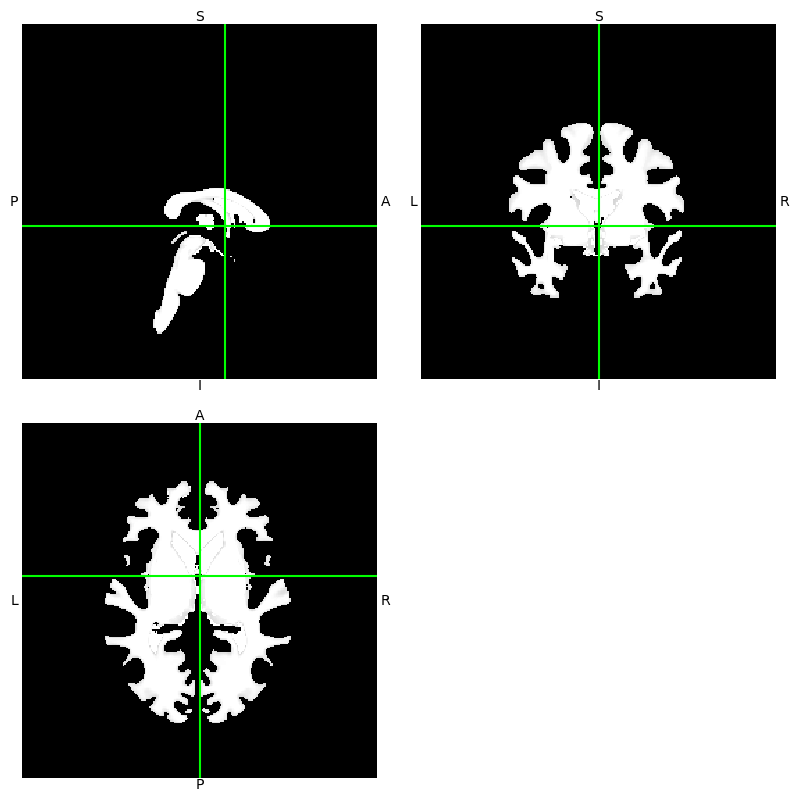

In [10]:
t1_img = nib.load(f"{SUBJECT_DIR}/mri/wm.mgz")
t1_data = t1_img.get_fdata()
t1_img.orthoview()
t1_img.shape